In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
df = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type','avg_glucose_level', 'bmi', 'smoking_status', 'stroke']]

##### Handling the outliers

In [4]:
df['bmi'] = df['bmi'].apply(lambda x: 47 if x > 47 else x)
df['avg_glucose_level'] = df['avg_glucose_level'].apply(lambda x: 170 if x > 170 else x)

#### Handling the null values for BMI  

In [5]:
#based on the plot for bmi we can see that it is not normally distributed so we will be filling in the missing values using 
#the medium
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

#### Transform the variables that are an object datatype

In [6]:
le = LabelEncoder()

In [7]:
#we do label encoding on these columns
df['gender'] = le.fit_transform(df['gender'])
df['ever_married'] = le.fit_transform(df['ever_married'])

In [8]:
#creating the hot encoder for work type, residence type, and smoking status since, they are not ordinal we 
#cant jsut integer encode it we have to use a different method
#like one hot encoding
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df[['work_type']]).toarray())
df = df.join(encoder_df)
df.rename(columns = {0:'Private', 1:'Self-employed', 2:'Govt_job', 3:'children', 4:'Never_worked'}, inplace = True)
encoder_df2 = pd.DataFrame(encoder.fit_transform(df[['Residence_type']]).toarray())
df = df.join(encoder_df2)
df.rename(columns = {0:'Urban', 1:'Rural'}, inplace = True)
encoder_df3 = pd.DataFrame(encoder.fit_transform(df[['smoking_status']]).toarray())
df = df.join(encoder_df3)
df.rename(columns = {0:'formerly smoked', 1:'never smoked', 2:'smokes', 3:'Unknown'}, inplace = True)

### Createing input and output

In [9]:
x = df[[ 'age', 'gender', 'bmi', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked', 'Urban', 'Rural', 'formerly smoked', 'never smoked', 'smokes', 'Unknown']]
y = df[['stroke']]

### Feature Engineering 

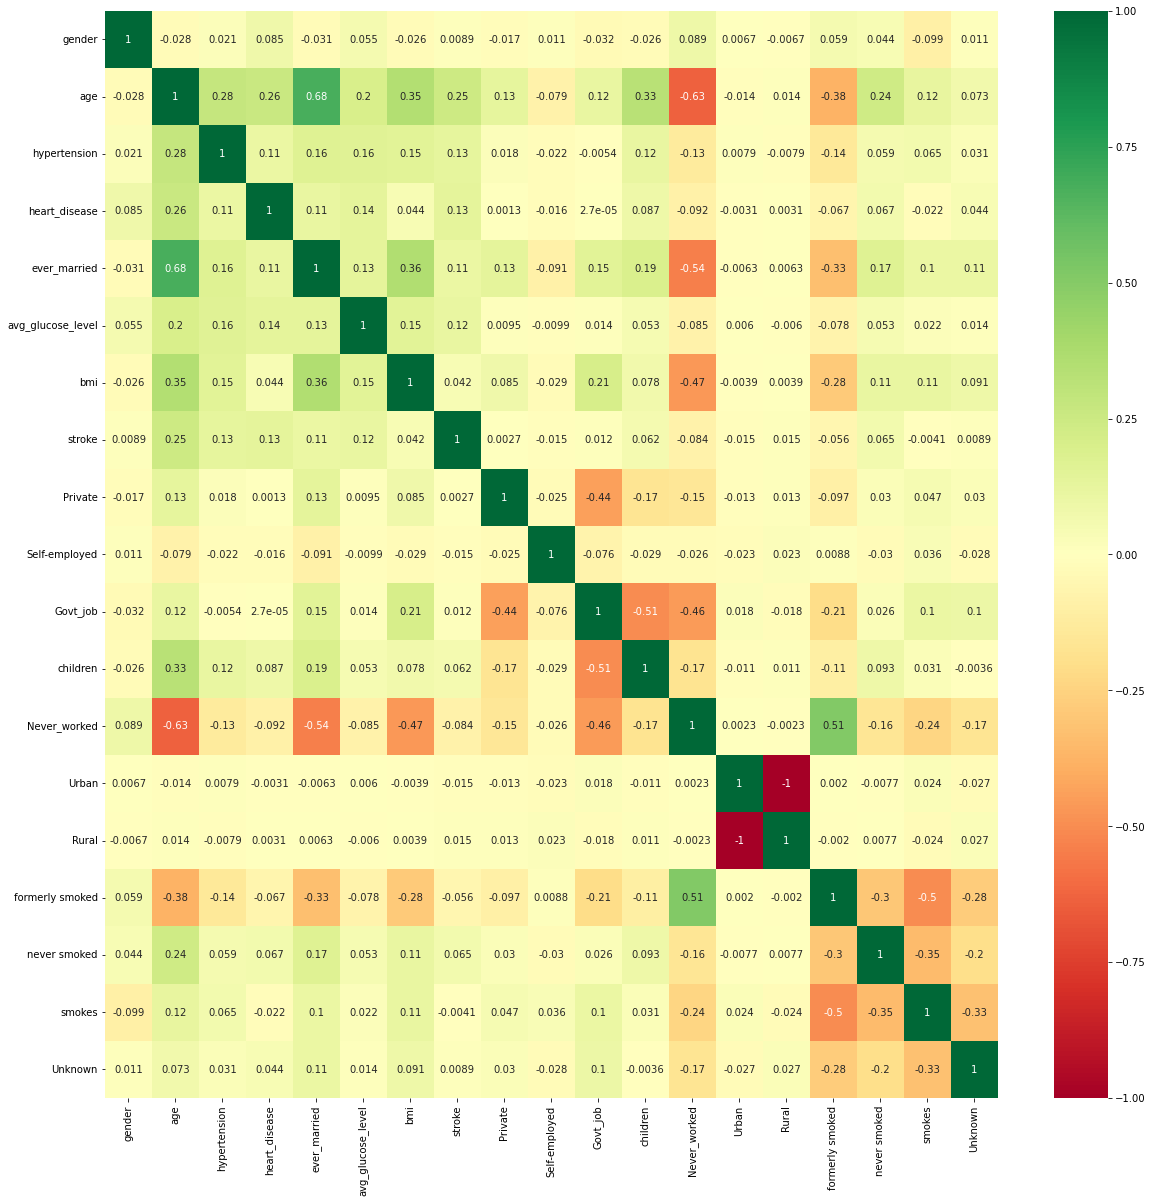

In [10]:
#graph to see the feature correlation
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (20,20))
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [11]:
#preparing the selectkbest
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
#creates a quick graph to show the features and their score
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']

In [12]:
featureScores

,Features,Score
0,age,3635.226911
1,gender,0.239001
2,bmi,16.256509
3,hypertension,75.449498
4,heart_disease,87.987436
5,ever_married,20.622787
6,avg_glucose_level,757.944821
7,Private,0.031905
8,Self-employed,1.126929
9,Govt_job,0.308806


In [13]:
print(featureScores.nlargest(10,'Score'))

             Features        Score
0                 age  3635.226911
6   avg_glucose_level   757.944821
4       heart_disease    87.987436
3        hypertension    75.449498
11       Never_worked    31.111620
5        ever_married    20.622787
15       never smoked    17.607359
10           children    16.584252
2                 bmi    16.256509
14    formerly smoked    11.139767


### Standarizing the data

In [14]:
#scaler = StandardScaler().fit(df)
#sD = scaler.transform(df)
#sD = pd.DataFrame(sD, index=df.index,columns=df.columns)
scaler = StandardScaler()
df[['age', 'avg_glucose_level','bmi']] = scaler.fit_transform(df[['age','avg_glucose_level','bmi']])

In [15]:
# normalize columns A and B
df[['age', 'avg_glucose_level', 'bmi']] = df[['age', 'avg_glucose_level', 'bmi']].apply(lambda x: x/x.max(), axis=0)

### moving our dataframe into input

In [16]:
x = df

In [17]:
x

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,...,Self-employed,Govt_job,children,Never_worked,Urban,Rural,formerly smoked,never smoked,smokes,Unknown
0,1,0.613137,0,1,1,Private,Urban,1.000000,0.431479,formerly smoked,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0,0.458391,0,0,1,Self-employed,Rural,1.000000,-0.033178,never smoked,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,0.948418,0,1,1,Private,Rural,0.070298,0.207350,never smoked,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0,0.148901,0,0,1,Private,Urban,1.000000,0.311215,smokes,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,0.922627,1,0,1,Self-employed,Rural,1.000000,-0.257307,never smoked,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,0.948418,1,0,1,Private,Urban,-0.251355,-0.033178,never smoked,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5106,0,0.974209,0,0,1,Self-employed,Urban,0.350021,0.617341,never smoked,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5107,0,-0.212172,0,0,1,Self-employed,Rural,-0.262381,0.103486,never smoked,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,1,0.200483,0,0,1,Private,Rural,0.946174,-0.169842,formerly smoked,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Dropping columns that are not needed 

In [18]:
x = x.drop(['gender'], axis = 1)
x = x.drop(['Private'], axis = 1)
x = x.drop([ 'Self-employed' ], axis = 1)
x = x.drop(['Govt_job' ], axis = 1)
x = x.drop(['smokes'], axis = 1)
x = x.drop(['Unknown'  ], axis = 1)
x = x.drop(['work_type'], axis = 1)
x = x.drop(['Residence_type'  ], axis = 1)
x = x.drop(['smoking_status'  ], axis = 1)

In [19]:
x

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,children,Never_worked,Urban,Rural,formerly smoked,never smoked
0,0.613137,0,1,1,1.000000,0.431479,1,0.0,0.0,0.0,1.0,0.0,1.0
1,0.458391,0,0,1,1.000000,-0.033178,1,1.0,0.0,1.0,0.0,0.0,0.0
2,0.948418,0,1,1,0.070298,0.207350,1,0.0,0.0,1.0,0.0,0.0,0.0
3,0.148901,0,0,1,1.000000,0.311215,1,0.0,0.0,0.0,1.0,0.0,0.0
4,0.922627,1,0,1,1.000000,-0.257307,1,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0.948418,1,0,1,-0.251355,-0.033178,0,0.0,0.0,0.0,1.0,0.0,0.0
5106,0.974209,0,0,1,0.350021,0.617341,0,1.0,0.0,0.0,1.0,0.0,0.0
5107,-0.212172,0,0,1,-0.262381,0.103486,0,1.0,0.0,1.0,0.0,0.0,0.0
5108,0.200483,0,0,1,0.946174,-0.169842,0,0.0,0.0,1.0,0.0,0.0,1.0


### splitting our data into test and training 

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

In [21]:
y_test = y_test['stroke'].values
y_train = y_train['stroke'].values

### applying SMOTE

In [22]:
print("\n\t Pre oversampling, the shape of x_train:{}".format(x_train.shape))
#print("\n\t Pre oversampling, the shape of y_train:{}".format(y_transTrain.shape))
print("\n\t Pre oversampling, the shape of y_train:{}".format(y_train.shape))


	 Pre oversampling, the shape of x_train:(4088, 13)

	 Pre oversampling, the shape of y_train:(4088,)


In [23]:
print("Pre OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
#print("Pre OverSampling, counts of label '0': {}".format(sum(y_transTrain== 0)
print("Pre OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Pre OverSampling, counts of label '1': 195
Pre OverSampling, counts of label '0': 3893


In [24]:
sm = SMOTE(sampling_strategy = 0.3, k_neighbors = 5, random_state = 100)

In [25]:
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

In [26]:
print("\n\t Post oversampling, the shape of x_train_res:{}".format(x_train_res.shape))
print("\n\t Post oversampling, the shape of y_train_res:{}".format(y_train_res.shape))


	 Post oversampling, the shape of x_train_res:(5060, 13)

	 Post oversampling, the shape of y_train_res:(5060,)


In [27]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, counts of label '1': 1167
After OverSampling, counts of label '0': 3893


### Building a Logistic Regression Model Using Training Set 

In [28]:
model = LogisticRegression()

In [29]:
model.fit(x_train_res, y_train_res)

LogisticRegression()

#### Predicting accuracy score for testing data  and training to compare and other scores

In [30]:
ypredTest = model.predict(x_test)
LogisticRegs, LogisticRegt, _ = roc_curve(y_test, ypredTest)
accuracyTest = accuracy_score(y_test, ypredTest)
print("accuracy for model on testing data is:", accuracyTest.round(4))
ypredTrain = model.predict(x_train_res)
accuracyTrain = accuracy_score(y_train_res, ypredTrain)
print("accuracy for model on training data is:", accuracyTrain.round(2))
auc_roc = roc_auc_score(y_test, ypredTest)
print('AUC-ROC score:', auc_roc)
f_score = f1_score(y_test, ypredTest)
print('F-score :', f_score)

accuracy for model on testing data is: 1.0
accuracy for model on training data is: 1.0
AUC-ROC score: 1.0
F-score : 1.0


### Building a Naive Bayes Model using the Training set

In [31]:
nb_model = GaussianNB()

In [32]:
nb_model.fit(x_train_res, y_train_res)

GaussianNB()

#### Predicting accuracy score for testing data  and training to compare

In [34]:
ypredTest2 = nb_model.predict(x_test)
accuracyTest2 = accuracy_score(y_test, ypredTest2)
print("accuracy for model on testing data is:", accuracyTest2.round(2))
NaiveBr, NaiveBm, _ = roc_curve(y_test, ypredTest2)
y_predTrain2 = nb_model.predict(x_train_res)
accuracyTrain2 = accuracy_score(y_train_res, y_predTrain2)
print("accuracy for model on training data is:", accuracyTrain2.round(2))
f2_score = f1_score(y_test, ypredTest2)
print('F-score:', f_score)
auc_roc = roc_auc_score(y_test, ypredTest2)
print('AUC-ROC score:', auc_roc)

accuracy for model on testing data is: 1.0
accuracy for model on training data is: 1.0
F-score: 1.0
AUC-ROC score: 0.9814814814814814


### Building a K-Nearest Neighbor Classifier model using Training Set 

In [35]:
knn = KNeighborsClassifier(n_neighbors=3)

In [36]:
# Train the model on the training data
knn.fit(x_train_res, y_train_res)

KNeighborsClassifier(n_neighbors=3)

#### Predicting accuracy score for testing data  and training to compare

In [38]:
# Make predictions on the testing data
ypredTest3 = knn.predict(x_test)
KNearr, KNeart, _ = roc_curve(y_test, ypredTest3)
accuracyTest3 = accuracy_score(y_test, ypredTest3)
print("accuracy for model on testing data is:", accuracyTest3.round(3))
# Make predictions on the training data
ypredTrain3 = knn.predict(x_train_res)
accuracyTrain3 = accuracy_score(y_train_res, ypredTrain3)
print("accuracy for model on training data is:", accuracyTrain3.round(3))
f2_score = f1_score(y_test, ypredTest3)
auc_roc = roc_auc_score(y_test, ypredTest3)
print('AUC-ROC:', auc_roc)
print('F-score:', f_score)

accuracy for model on testing data is: 0.996
accuracy for model on training data is: 1.0
AUC-ROC: 0.962962962962963
F-score: 1.0


### Build a  Support Vector Machine Classifier model using the training set.

In [39]:
svm = SVC()
# Train the model on the training data
svm.fit(x_train_res, y_train_res)


SVC()

#### Predicting accuracy score for testing data  and training to compare

In [40]:
# Make predictions on the testing data
ypredTest4 = svm.predict(x_test)
SVectorr, SVectort, _ = roc_curve(y_test, ypredTest4)
accuracyTest4 = accuracy_score(y_test, ypredTest4)
print("accuracy for model on testing data is:", accuracyTest4.round(2))
# Make predictions on the training data
ypredTrain4 = svm.predict(x_train_res)
accuracyTrain4 = accuracy_score(y_train_res, ypredTrain4)
print("accuracy for model on training data is:", accuracyTrain4.round(2))
f2_score = f1_score(y_test, ypredTest4)
auc_roc = roc_auc_score(y_test, ypredTest4)
print('AUC-ROC score:', auc_roc)
print('F-score:', f_score)

accuracy for model on testing data is: 1.0
accuracy for model on training data is: 1.0
AUC-ROC score: 0.9814814814814814
F-score: 1.0


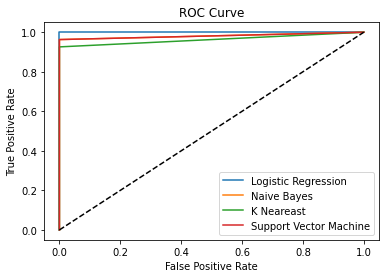

In [41]:
plt.plot(LogisticRegs, LogisticRegt, label='Logistic Regression')
plt.plot(NaiveBr,NaiveBm, label="Naive Bayes")
plt.plot(KNearr,KNeart, label="K Neareast")
plt.plot(SVectorr,SVectort, label="Support Vector Machine")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()